<a href="https://colab.research.google.com/github/RiseAboveAll/Health-Insurance/blob/main/HealthLeadPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Health Insurance Lead Prediction</h1>
<body>
    
Your Client FinMan is a financial services company that provides various financial services like loan, investment funds, insurance etc. to its customers. FinMan wishes to cross-sell health insurance to the existing customers who may or may not hold insurance policies with the company. The company recommend health insurance to it's customers based on their profile once these customers land on the website. Customers might browse the recommended health insurance policy and consequently fill up a form to apply. When these customers fill-up the form, their Response towards the policy is considered positive and they are classified as a lead.

Once these leads are acquired, the sales advisors approach them to convert and thus the company can sell proposed health insurance to these leads in a more efficient manner.

Now the company needs your help in building a model to predict whether the person will be interested in their proposed Health plan/policy
    
</body>

In [ ]:
!pip install lightgbm

In [ ]:
from lightgbm import LGBMClassifier
import lightgbm as lgb

In [ ]:
try:
    # To enable interactive mode you should install ipywidgets
    # https://github.com/jupyter-widgets/ipywidgets
    from ipywidgets import interact, SelectMultiple
    INTERACTIVE = True
except ImportError:
    INTERACTIVE = False

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,normalize,Normalizer,StandardScaler
from sklearn.model_selection import train_test_split as tts
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import re

In [ ]:
pd.set_option('display.max_columns',500)

In [ ]:
train_Data=pd.read_csv('train.csv')
test_Data=pd.read_csv('test.csv')

In [ ]:
train_Data.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0


In [ ]:
train_Data['is_Train']=1
test_Data['is_Train']=0
concat_Data=pd.concat([train_Data,test_Data],axis=0)

In [ ]:
concat_Data.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,is_Train
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0.0,1
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0.0,1
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1.0,1
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0.0,1
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0.0,1


In [ ]:
concat_Data['is_Train'].value_counts()

1    50882
0    21805
Name: is_Train, dtype: int64

In [ ]:
concat_Data.dtypes

ID                           int64
City_Code                   object
Region_Code                  int64
Accomodation_Type           object
Reco_Insurance_Type         object
Upper_Age                    int64
Lower_Age                    int64
Is_Spouse                   object
Health Indicator            object
Holding_Policy_Duration     object
Holding_Policy_Type        float64
Reco_Policy_Cat              int64
Reco_Policy_Premium        float64
Response                   float64
is_Train                     int64
dtype: object

### Pre-Processing

#### Treating Anomalies

In [ ]:
concat_Data['Holding_Policy_Duration'].value_counts()

1.0     6390
14+     6227
2.0     6032
3.0     5192
4.0     3976
5.0     3354
6.0     2797
7.0     2309
8.0     1885
9.0     1607
10.0    1146
11.0     800
13.0     732
12.0     709
14.0     677
Name: Holding_Policy_Duration, dtype: int64

As we can see a string value 14+ in the holding policy duration column which means duration of policy is 14 and more , it need to be treated 

In [ ]:
concat_Data['Holding_Policy_Duration'].replace({'14+':14.0},inplace=True)

In [ ]:
concat_Data.isna().sum()[concat_Data.isna().any()>0]/concat_Data.shape[0]

Health Indicator           0.230000
Holding_Policy_Duration    0.396962
Holding_Policy_Type        0.396962
Response                   0.299985
dtype: float64

Apart from Response variable we need to treat rest other variable for missing values. 

    -Health Indicateor : String Categorical
    -Holding Policy Duration : Num Categorical (impute with negative high number so that information is not lost and algorithm knows that there lies pattern of missing values)
    -Holding Policy Type : Num Categorical  (impute with negative high number so that information is not lost and algorithm knows that there lies pattern of missing values)

In [ ]:
def missing_treatment(df,x,type_Operation):
    if type_Operation == "Categorical" or type_Operation == "categorical":
        return df[x].fillna(df[x].mode(dropna=True)[0],inplace=True)
    elif type_Operation == 'Numeric' or type_Operation =='numeric':
        return df[x].fillna(-999.0,inplace=True)
    

In [ ]:
na_col=concat_Data.isna().sum()[concat_Data.isna().any()>0].index[:3].values

In [ ]:
na_col

array(['Health Indicator', 'Holding_Policy_Duration',
       'Holding_Policy_Type'], dtype=object)

In [ ]:
for i in na_col:
    if i=='Health Indicator':
        missing_treatment(concat_Data,i,type_Operation="Categorical")
    else:
        missing_treatment(concat_Data,i,type_Operation="numeric")
        
        

Convert Holing Policy Duration to numerical from object data type

In [ ]:
concat_Data['Holding_Policy_Duration']=concat_Data['Holding_Policy_Duration'].astype('float64')

Segregate Categorical Columns and Numerical Columns

In [ ]:
categ_data=concat_Data.select_dtypes('object')

Encoding Variables

In [ ]:
categ_data['Accomodation_Type'].replace({'Rented':0,'Owned':1},inplace=True)
categ_data['Reco_Insurance_Type'].replace({"Individual":0,"Joint":1},inplace=True)
categ_data['Is_Spouse'].replace({"No":0,"Yes":1},inplace=True)

D:\anacond\lib\site-packages\pandas\core\series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [ ]:
categ_data=pd.concat([categ_data.drop('Health Indicator',axis=1),pd.get_dummies(categ_data['Health Indicator'])],axis=1)

In [ ]:
la_enc=LabelEncoder()
la_enc.fit(categ_data['City_Code'])


LabelEncoder()

In [ ]:
categ_data['City_Code']=la_enc.transform(categ_data['City_Code'])

In [ ]:
num_data=concat_Data.select_dtypes(['int64','float64'])

In [ ]:
num_data.head()

,ID,Region_Code,Upper_Age,Lower_Age,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,is_Train
0,1,3213,36,36,14.0,3.0,22,11628.0,0.0,1
1,2,1117,75,22,-999.0,-999.0,22,30510.0,0.0,1
2,3,3732,32,32,1.0,1.0,19,7450.0,1.0,1
3,4,4378,52,48,14.0,3.0,19,17780.0,0.0,1
4,5,2190,44,44,3.0,1.0,16,10404.0,0.0,1


In [ ]:
final_data=pd.concat([num_data,categ_data],axis=1)

In [ ]:
final_data.head()

,ID,Region_Code,Upper_Age,Lower_Age,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,is_Train,City_Code,Accomodation_Type,Reco_Insurance_Type,Is_Spouse,X1,X2,X3,X4,X5,X6,X7,X8,X9
0,1,3213,36,36,14.0,3.0,22,11628.0,0.0,1,22,0,0,0,1,0,0,0,0,0,0,0,0
1,2,1117,75,22,-999.0,-999.0,22,30510.0,0.0,1,31,1,1,0,0,1,0,0,0,0,0,0,0
2,3,3732,32,32,1.0,1.0,19,7450.0,1.0,1,31,1,0,0,1,0,0,0,0,0,0,0,0
3,4,4378,52,48,14.0,3.0,19,17780.0,0.0,1,16,1,1,0,1,0,0,0,0,0,0,0,0
4,5,2190,44,44,3.0,1.0,16,10404.0,0.0,1,34,0,0,0,0,1,0,0,0,0,0,0,0


Feature Engineering - Binning

In [ ]:
final_data['Upper_Age_bin']=pd.qcut(final_data['Upper_Age'],5).astype('object').astype(str)
final_data['Lower_Age_bin']=pd.qcut(final_data['Lower_Age'],5).astype('object').astype(str)

In [ ]:
la_enc=LabelEncoder()
la_enc.fit(final_data['Upper_Age_bin'])
final_data['Upper_Age_bin']=la_enc.transform(final_data['Upper_Age_bin'])

In [ ]:
final_data.head()

,ID,Region_Code,Upper_Age,Lower_Age,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,is_Train,City_Code,Accomodation_Type,Reco_Insurance_Type,Is_Spouse,X1,X2,X3,X4,X5,X6,X7,X8,X9,Upper_Age_bin,Lower_Age_bin
0,1,3213,36,36,14.0,3.0,22,11628.0,0.0,1,22,0,0,0,1,0,0,0,0,0,0,0,0,1,"(34.0, 47.0]"
1,2,1117,75,22,-999.0,-999.0,22,30510.0,0.0,1,31,1,1,0,0,1,0,0,0,0,0,0,0,4,"(15.999, 25.0]"
2,3,3732,32,32,1.0,1.0,19,7450.0,1.0,1,31,1,0,0,1,0,0,0,0,0,0,0,0,1,"(25.0, 34.0]"
3,4,4378,52,48,14.0,3.0,19,17780.0,0.0,1,16,1,1,0,1,0,0,0,0,0,0,0,0,3,"(47.0, 61.0]"
4,5,2190,44,44,3.0,1.0,16,10404.0,0.0,1,34,0,0,0,0,1,0,0,0,0,0,0,0,2,"(34.0, 47.0]"


In [ ]:
la_enc=LabelEncoder()
la_enc.fit(final_data['Lower_Age_bin'])
final_data['Lower_Age_bin']=la_enc.transform(final_data['Lower_Age_bin'])

In [ ]:
final_data.head()

,ID,Region_Code,Upper_Age,Lower_Age,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,is_Train,City_Code,Accomodation_Type,Reco_Insurance_Type,Is_Spouse,X1,X2,X3,X4,X5,X6,X7,X8,X9,Upper_Age_bin,Lower_Age_bin
0,1,3213,36,36,14.0,3.0,22,11628.0,0.0,1,22,0,0,0,1,0,0,0,0,0,0,0,0,1,2
1,2,1117,75,22,-999.0,-999.0,22,30510.0,0.0,1,31,1,1,0,0,1,0,0,0,0,0,0,0,4,0
2,3,3732,32,32,1.0,1.0,19,7450.0,1.0,1,31,1,0,0,1,0,0,0,0,0,0,0,0,1,1
3,4,4378,52,48,14.0,3.0,19,17780.0,0.0,1,16,1,1,0,1,0,0,0,0,0,0,0,0,3,3
4,5,2190,44,44,3.0,1.0,16,10404.0,0.0,1,34,0,0,0,0,1,0,0,0,0,0,0,0,2,2


Feature Engineering 

In [ ]:
final_data['ageDiff']=final_data['Upper_Age']-final_data['Lower_Age']

In [ ]:
final_data['Premium_by_uage']=final_data['Reco_Policy_Premium']/final_data['Upper_Age'].astype(float)

In [ ]:
final_data['Premium_by_lage']=final_data['Reco_Policy_Premium']/final_data['Lower_Age'].astype(float)
final_data['Premium_by_age_Diff']=final_data['Reco_Policy_Premium']/final_data['ageDiff'].astype(float)

In [ ]:
final_data.head()

,ID,Region_Code,Upper_Age,Lower_Age,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,is_Train,City_Code,Accomodation_Type,Reco_Insurance_Type,Is_Spouse,X1,X2,X3,X4,X5,X6,X7,X8,X9,Upper_Age_bin,Lower_Age_bin,ageDiff,Premium_by_uage,Premium_by_lage,Premium_by_age_Diff
0,1,3213,36,36,14.0,3.0,22,11628.0,0.0,1,22,0,0,0,1,0,0,0,0,0,0,0,0,1,2,0,323.000000,323.000000,inf
1,2,1117,75,22,-999.0,-999.0,22,30510.0,0.0,1,31,1,1,0,0,1,0,0,0,0,0,0,0,4,0,53,406.800000,1386.818182,575.660377
2,3,3732,32,32,1.0,1.0,19,7450.0,1.0,1,31,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,232.812500,232.812500,inf
3,4,4378,52,48,14.0,3.0,19,17780.0,0.0,1,16,1,1,0,1,0,0,0,0,0,0,0,0,3,3,4,341.923077,370.416667,4445.000000
4,5,2190,44,44,3.0,1.0,16,10404.0,0.0,1,34,0,0,0,0,1,0,0,0,0,0,0,0,2,2,0,236.454545,236.454545,inf


In [ ]:
final_data['Premium_by_age_Diff'].replace({np.inf:-1},inplace=True)

In [ ]:
final_data.head()

,ID,Region_Code,Upper_Age,Lower_Age,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,is_Train,City_Code,Accomodation_Type,Reco_Insurance_Type,Is_Spouse,X1,X2,X3,X4,X5,X6,X7,X8,X9,Upper_Age_bin,Lower_Age_bin,ageDiff,Premium_by_uage,Premium_by_lage,Premium_by_age_Diff
0,1,3213,36,36,14.0,3.0,22,11628.0,0.0,1,22,0,0,0,1,0,0,0,0,0,0,0,0,1,2,0,323.000000,323.000000,-1.000000
1,2,1117,75,22,-999.0,-999.0,22,30510.0,0.0,1,31,1,1,0,0,1,0,0,0,0,0,0,0,4,0,53,406.800000,1386.818182,575.660377
2,3,3732,32,32,1.0,1.0,19,7450.0,1.0,1,31,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,232.812500,232.812500,-1.000000
3,4,4378,52,48,14.0,3.0,19,17780.0,0.0,1,16,1,1,0,1,0,0,0,0,0,0,0,0,3,3,4,341.923077,370.416667,4445.000000
4,5,2190,44,44,3.0,1.0,16,10404.0,0.0,1,34,0,0,0,0,1,0,0,0,0,0,0,0,2,2,0,236.454545,236.454545,-1.000000


In [ ]:
final_data['Premium_Ratio_byAge']=final_data['Premium_by_lage']/final_data['Premium_by_uage']

In [ ]:
final_data.head()

,ID,Region_Code,Upper_Age,Lower_Age,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,is_Train,City_Code,Accomodation_Type,Reco_Insurance_Type,Is_Spouse,X1,X2,X3,X4,X5,X6,X7,X8,X9,Upper_Age_bin,Lower_Age_bin,ageDiff,Premium_by_uage,Premium_by_lage,Premium_by_age_Diff,Premium_Ratio_byAge
0,1,3213,36,36,14.0,3.0,22,11628.0,0.0,1,22,0,0,0,1,0,0,0,0,0,0,0,0,1,2,0,323.000000,323.000000,-1.000000,1.000000
1,2,1117,75,22,-999.0,-999.0,22,30510.0,0.0,1,31,1,1,0,0,1,0,0,0,0,0,0,0,4,0,53,406.800000,1386.818182,575.660377,3.409091
2,3,3732,32,32,1.0,1.0,19,7450.0,1.0,1,31,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,232.812500,232.812500,-1.000000,1.000000
3,4,4378,52,48,14.0,3.0,19,17780.0,0.0,1,16,1,1,0,1,0,0,0,0,0,0,0,0,3,3,4,341.923077,370.416667,4445.000000,1.083333
4,5,2190,44,44,3.0,1.0,16,10404.0,0.0,1,34,0,0,0,0,1,0,0,0,0,0,0,0,2,2,0,236.454545,236.454545,-1.000000,1.000000


Know the popularity

```
def popular_fe(df,x):
    num_counts=df[x].value_counts()
    feature_Name=str(x)+'_FE'
    df[feature_Name]=df[x].map(num_counts)
pop_cols=['Reco_Policy_Cat','City_Code','Premium_Ratio_byAge']
for i in pop_cols:
    popular_fe(final_data,i)
```

In [ ]:
final_data.drop(['Upper_Age','Lower_Age'],axis=1,inplace=True)

Feature Aggregation

In [ ]:
def top_ten(x):
    return x.nlargest(10).sum()
def bottom_ten(x):
    return x.nsmallest(10).sum()
def mode(x):
     return pd.Series.mode(x)[0]
 
    


For each city and policy recommended find :

    - Minimum Premium
    - Maximum Premium
    - Average Premium
    - Standard Deviation in Premium
    - Skewness in Premium

For each Region and policy recommendation find :

    - Minimum Premium
    - Maximum Premium
    - Average Premium
    - Standard Deviation in Premium
    - Skewness in Premium
    - Top 10 Premium Sum
    - Bottom 10 Premium Sum

    
    
For each Region Code find :

    - Policy Category Minimum
    - Policy Category Mode
    - Policy Category Counr
    
For each spouse category wise policy category :

    - Policy Premium Minimum
    - Policy Premium Maximum
    - Policy Premium Average
    - Policy Premium Skew
    - Policy Premium Standard Deviation
    - Policy Premium Top Ten
    - Policy Premium Bottom Ten
    
For Accomodation Type and Policy Category

    - Policy Premium Minimum
    - Policy Premium Maximum
    - Policy Premium Average
    - Policy Premium Skew
    - Policy Premium Standard Deviation
    - Policy Premium Top Ten
    - Policy Premium Bottom Ten

For Holding Policy Type and Policy Category :

    - Policy Premium Minimum
    - Policy Premium Maximum
    - Policy Premium Average
    - Policy Premium Skew
    - Policy Premium Standard Deviation
    - Policy Premium Top Ten
    - Policy Premium Bottom Ten


In [ ]:
Agg_recipes=[(['City_Code','Reco_Policy_Cat'],
             [
                 ('Reco_Policy_Premium','min'),
                 ('Reco_Policy_Premium','max'),
                 ('Reco_Policy_Premium','mean'),
                 ('Reco_Policy_Premium','std'),
                 ('Reco_Policy_Premium','skew')
             ]),
            (['Region_Code','Reco_Policy_Cat'],
            [
                 ('Reco_Policy_Premium','min'),
                 ('Reco_Policy_Premium','max'),
                 ('Reco_Policy_Premium','mean'),
                 ('Reco_Policy_Premium','std'),
                 ('Reco_Policy_Premium','skew'),
                 ('Reco_Policy_Premium',top_ten),
                 ('Reco_Policy_Premium',bottom_ten)
            ]),
             (['Region_Code'],
             [
                 
                 ('Reco_Policy_Cat','count'),
                 ('Reco_Policy_Cat',mode)
                 
                 
            ]),
             (['Is_Spouse','Reco_Policy_Cat'],
             [
                 ('Reco_Policy_Premium','min'),
                 ('Reco_Policy_Premium','max'),
                 ('Reco_Policy_Premium','mean'),
                 ('Reco_Policy_Premium','std'),
                 ('Reco_Policy_Premium','skew'),
                 ('Reco_Policy_Premium',top_ten),
                 ('Reco_Policy_Premium',bottom_ten)
                 
             ]),
             (['Accomodation_Type','Reco_Policy_Cat'],
             [
                 ('Reco_Policy_Premium','min'),
                 ('Reco_Policy_Premium','max'),
                 ('Reco_Policy_Premium','mean'),
                 ('Reco_Policy_Premium','std'),
                 ('Reco_Policy_Premium','skew'),
                 ('Reco_Policy_Premium',top_ten),
                 ('Reco_Policy_Premium',bottom_ten)
             ]),
             (['Holding_Policy_Type','Reco_Policy_Cat'],
             [
                 ('Reco_Policy_Premium','min'),
                 ('Reco_Policy_Premium','max'),
                 ('Reco_Policy_Premium','mean'),
                 ('Reco_Policy_Premium','std'),
                 ('Reco_Policy_Premium','skew'),
                 ('Reco_Policy_Premium',top_ten),
                 ('Reco_Policy_Premium',bottom_ten)
                 
             ])
            ]

In [ ]:
groupby_aggregate_names=[]
for groupby_cols,specs in tqdm(Agg_recipes):
    
    group_object=final_data.groupby(groupby_cols)
    for select , agg in specs:
        groupby_aggregate_name='{}_{}_{}'.format('_'.join(groupby_cols),agg,select)
        final_data=final_data.merge(group_object[select].agg(agg).reset_index().rename(index=str,columns={select:groupby_aggregate_name})[groupby_cols + [groupby_aggregate_name]],
        on=groupby_cols,
        how='left')
        groupby_aggregate_names.append(groupby_aggregate_name)


100%|██████████| 6/6 [00:39<00:00,  6.52s/it]


In [ ]:
cols=final_data.columns.values

In [ ]:
c="Region_Code_Reco_Policy_Cat_<function top_ten at 0x000002861135DA60>_Reco_Policy_Premium"

In [ ]:
match=re.search('function top_ten',c)

In [ ]:
print(match)

<re.Match object; span=(29, 45), match='function top_ten'>


In [ ]:
column=[]
pattern='function '
for i in cols:
    search=re.search(pattern,i)
    if search !=None:
        column.append(i)

In [ ]:
vals=['Region_Code_Reco_Policy_Cat_top_ten_Reco_Policy_Premium',
                          'Region_Code_Reco_Policy_Cat_bottom_ten_Reco_Policy_Premium',
                          'Region_Code_mode_Reco_Policy_Cat',
                          'Is_Spouse_Reco_Policy_Cat_top_ten_Reco_Policy_Premium',
                          'Is_Spouse_Reco_Policy_Cat_bottom_ten_Reco_Policy_Premium',
                          'Accomodation_Type_Reco_Policy_Cat_top_ten_Reco_Policy_Premium',
                          'Accomodation_Type_Reco_Policy_Cat_bottom_ten_Reco_Policy_Premium',
                          'Holding_Policy_Type_Reco_Policy_Cat_top_ten_Reco_Policy_Premium',
                          'Holding_Policy_Type_Reco_Policy_Cat_bottom_ten_Reco_Policy_Premium']

In [ ]:
cl={}
for i,j in zip(column,vals):
    cl[i]=j
    

In [ ]:
final_data.rename(columns=cl,inplace=True)

In [ ]:
final_data.head()

,ID,Region_Code,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,is_Train,City_Code,Accomodation_Type,Reco_Insurance_Type,Is_Spouse,X1,X2,X3,X4,X5,X6,X7,X8,X9,Upper_Age_bin,Lower_Age_bin,ageDiff,Premium_by_uage,Premium_by_lage,Premium_by_age_Diff,Premium_Ratio_byAge,City_Code_Reco_Policy_Cat_min_Reco_Policy_Premium,City_Code_Reco_Policy_Cat_max_Reco_Policy_Premium,City_Code_Reco_Policy_Cat_mean_Reco_Policy_Premium,City_Code_Reco_Policy_Cat_std_Reco_Policy_Premium,City_Code_Reco_Policy_Cat_skew_Reco_Policy_Premium,Region_Code_Reco_Policy_Cat_min_Reco_Policy_Premium,Region_Code_Reco_Policy_Cat_max_Reco_Policy_Premium,Region_Code_Reco_Policy_Cat_mean_Reco_Policy_Premium,Region_Code_Reco_Policy_Cat_std_Reco_Policy_Premium,Region_Code_Reco_Policy_Cat_skew_Reco_Policy_Premium,Region_Code_Reco_Policy_Cat_top_ten_Reco_Policy_Premium,Region_Code_Reco_Policy_Cat_bottom_ten_Reco_Policy_Premium,Region_Code_count_Reco_Policy_Cat,Region_Code_mode_Reco_Policy_Cat,Is_Spouse_Reco_Policy_Cat_min_Reco_Policy_Premium,Is_Spouse_Reco_Policy_Cat_max_Reco_Policy_Premium,Is_Spouse_Reco_Policy_Cat_mean_Reco_Policy_Premium,Is_Spouse_Reco_Policy_Cat_std_Reco_Policy_Premium,Is_Spouse_Reco_Policy_Cat_skew_Reco_Policy_Premium,Is_Spouse_Reco_Policy_Cat_top_ten_Reco_Policy_Premium,Is_Spouse_Reco_Policy_Cat_bottom_ten_Reco_Policy_Premium,Accomodation_Type_Reco_Policy_Cat_min_Reco_Policy_Premium,Accomodation_Type_Reco_Policy_Cat_max_Reco_Policy_Premium,Accomodation_Type_Reco_Policy_Cat_mean_Reco_Policy_Premium,Accomodation_Type_Reco_Policy_Cat_std_Reco_Policy_Premium,Accomodation_Type_Reco_Policy_Cat_skew_Reco_Policy_Premium,Accomodation_Type_Reco_Policy_Cat_top_ten_Reco_Policy_Premium,Accomodation_Type_Reco_Policy_Cat_bottom_ten_Reco_Policy_Premium,Holding_Policy_Type_Reco_Policy_Cat_min_Reco_Policy_Premium,Holding_Policy_Type_Reco_Policy_Cat_max_Reco_Policy_Premium,Holding_Policy_Type_Reco_Policy_Cat_mean_Reco_Policy_Premium,Holding_Policy_Type_Reco_Policy_Cat_std_Reco_Policy_Premium,Holding_Policy_Type_Reco_Policy_Cat_skew_Reco_Policy_Premium,Holding_Policy_Type_Reco_Policy_Cat_top_ten_Reco_Policy_Premium,Holding_Policy_Type_Reco_Policy_Cat_bottom_ten_Reco_Policy_Premium
0,1,3213,14.0,3.0,22,11628.0,0.0,1,22,0,0,0,1,0,0,0,0,0,0,0,0,1,2,0,323.000000,323.000000,-1.000000,1.000000,2712.0,35037.0,14070.144906,6524.113998,0.782848,11628.0,11628.0,11628.000000,NaN,NaN,11628.0,11628.0,10,21,2464.0,42316.8,12844.677482,5585.664161,0.729565,381585.4,26664.0,2464.0,42256.0,11508.456109,5536.345460,1.153912,365912.6,26908.0,3564.0,42256.0,15732.582955,6512.425453,0.760213,393472.4,38694.0
1,2,1117,-999.0,-999.0,22,30510.0,0.0,1,31,1,1,0,0,1,0,0,0,0,0,0,0,4,0,53,406.800000,1386.818182,575.660377,3.409091,4074.0,39398.4,13939.150943,6915.153685,0.976274,4074.0,39398.4,17596.550000,9248.842701,0.732180,226504.8,121165.6,21,22,2464.0,42316.8,12844.677482,5585.664161,0.729565,381585.4,26664.0,2756.0,42316.8,16964.571921,6853.286222,0.580590,407712.8,34380.0,2464.0,42012.8,12718.762652,6716.173112,1.023065,387708.8,26664.0
2,3,3732,1.0,1.0,19,7450.0,1.0,1,31,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,232.812500,232.812500,-1.000000,1.000000,4410.0,32895.0,14485.746552,5991.594892,0.671089,7450.0,9086.0,8268.000000,1156.826694,NaN,16536.0,16536.0,8,1,2624.0,43046.4,13234.166472,5413.367635,0.681709,370114.6,31034.0,2960.0,43046.4,16714.339386,6454.583281,0.603557,386338.4,38144.0,3822.0,43046.4,15229.894398,5943.634696,0.661052,365056.0,39780.0
3,4,4378,14.0,3.0,19,17780.0,0.0,1,16,1,1,0,1,0,0,0,0,0,0,0,0,3,3,4,341.923077,370.416667,4445.000000,1.083333,4182.0,43046.4,15636.087059,7030.083929,1.014122,17780.0,17780.0,17780.000000,NaN,NaN,17780.0,17780.0,5,2,2624.0,43046.4,13234.166472,5413.367635,0.681709,370114.6,31034.0,2960.0,43046.4,16714.339386,6454.583281,0.603557,386338.4,38144.0,3930.0,37506.0,16767.614763,6861.891760,0.546000,357690.8,44854.0
4,5,2190,3.0,1.0,16,10404.0,0.0,1,34,0,0,0,0,1,0,0,0,0,0,0,0,2,2,0,236.454545,236.454545,-1.000000,

Segregate Train and Test Data

In [ ]:
train_data,test_data=final_data[final_data['is_Train']==1],final_data[final_data['is_Train']==0]

Drop Columns Response and is_Train from test and is_Train from train

In [ ]:
train_data.drop(['is_Train'],axis=1,inplace=True)
test_data.drop(['is_Train','Response'],axis=1,inplace=True)

D:\anacond\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Explore Data

In [ ]:
pd.crosstab(train_data['Is_Spouse'],train_data['Response'],normalize='index').sort_values(by=[1],ascending=False)

Response,0.0,1.0
Is_Spouse,,
1,0.756352,0.243648
0,0.760787,0.239213


<AxesSubplot:xlabel='Is_Spouse'>

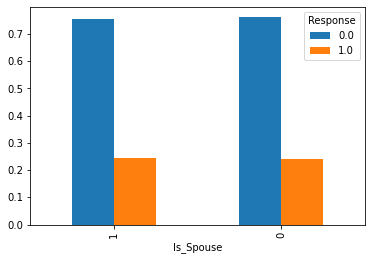

In [ ]:
pd.crosstab(train_data['Is_Spouse'],train_data['Response'],normalize='index').sort_values(by=[1],ascending=False).plot(kind='bar')

In [ ]:
pd.crosstab(train_data['City_Code'],train_data['Response'],normalize='index').sort_values(by=[1],ascending=False).head(5)

Response,0.0,1.0
City_Code,,
23,0.689655,0.310345
25,0.712500,0.287500
28,0.714286,0.285714
27,0.723077,0.276923
15,0.734242,0.265758


<AxesSubplot:xlabel='City_Code'>

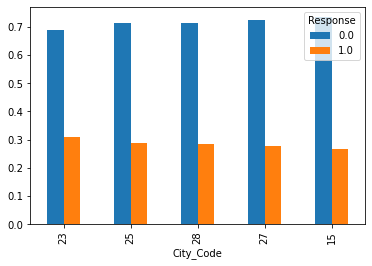

In [ ]:
pd.crosstab(train_data['City_Code'],train_data['Response'],normalize='index').sort_values(by=[1],ascending=False).head(5).plot(kind='bar')

In [ ]:
pd.crosstab(train_data['Is_Spouse'],train_data['Response'],train_data['Reco_Policy_Premium'],aggfunc='mean',normalize='index')

Response,0.0,1.0
Is_Spouse,,
0,0.498006,0.501994
1,0.499480,0.500520


Average Premium of Is Spouse category per Response type has distribution of 50%:50%. Average Premium per spouse category does not explains target varable, as average premium for all the combinations is .50(Approx).

In [ ]:
pd.crosstab(train_data['Is_Spouse'],train_data['Response'],train_data['Reco_Policy_Premium'],aggfunc='median',normalize='index')

Response,0.0,1.0
Is_Spouse,,
0,0.497316,0.502684
1,0.501002,0.498998


Average Premium of Is Spouse category per Response type has distribution of 50%:50%. Average Premium per spouse category does not explains target varable, as average premium for all the combinations is .50(Approx).

<AxesSubplot:xlabel='Is_Spouse'>

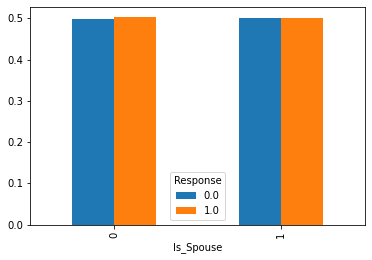

In [ ]:
pd.crosstab(train_data['Is_Spouse'],train_data['Response'],train_data['Reco_Policy_Premium'],aggfunc='mean',normalize='index').plot(kind='bar')

In [ ]:
pd.crosstab(train_data['Holding_Policy_Duration'],train_data['Response'],normalize='index').sort_values(by=[1],ascending=False)[:5]

Response,0.0,1.0
Holding_Policy_Duration,,
10.0,0.726937,0.273063
13.0,0.729941,0.270059
7.0,0.742857,0.257143
8.0,0.743161,0.256839
12.0,0.746589,0.253411
11.0,0.749084,0.250916
14.0,0.749635,0.250365
4.0,0.759293,0.240707
-999.0,0.761049,0.238951


Distribution of Holding Policy Duration to Response type is 75%:25%(Approx). Which states that there is approximately 25% probability for positive response type.

In [ ]:
pd.crosstab(train_data['Holding_Policy_Duration'],train_data['Response'],train_data['Reco_Policy_Premium'],aggfunc='mean',normalize='index').sort_values(by=[1],ascending=False)[:5]

Response,0.0,1.0
Holding_Policy_Duration,,
11.0,0.485970,0.514030
9.0,0.494701,0.505299
8.0,0.495625,0.504375
14.0,0.495968,0.504032
-999.0,0.496185,0.503815
3.0,0.497857,0.502143
7.0,0.498797,0.501203
4.0,0.499473,0.500527
10.0,0.500613,0.499387


In [ ]:
pd.crosstab(train_data['Holding_Policy_Type'],train_data['Response'],normalize='index').sort_values(by=[1],ascending=False)

Response,0.0,1.0
Holding_Policy_Type,,
4.0,0.751797,0.248203
3.0,0.757738,0.242262
-999.0,0.761049,0.238951
2.0,0.762238,0.237762
1.0,0.764224,0.235776


In [ ]:
pd.crosstab(train_data['Reco_Policy_Cat'],train_data['Response'],normalize='index').sort_values(by=[1],ascending=False)[:5]

Response,0.0,1.0
Reco_Policy_Cat,,
15,0.534365,0.465635
22,0.671615,0.328385
12,0.684963,0.315037
17,0.701544,0.298456
5,0.709037,0.290963


In [ ]:
pd.crosstab(train_data['Is_Spouse'],train_data['Response'],train_data['Premium_Ratio_byAge'],aggfunc='mean').sort_values(by=[1],ascending=False)

Response,0.0,1.0
Is_Spouse,,
1,1.262097,1.274921
0,1.043619,1.051269


We notice that within same spouse category it is hard to state difference for each response type, distribution is approximately same. But when we compare the categories of Spouse type , we can see the change in distribution. Which means for non married , the upper age has to spend less in comparison to married. But we can not distinguish for response categories for each spouse type.

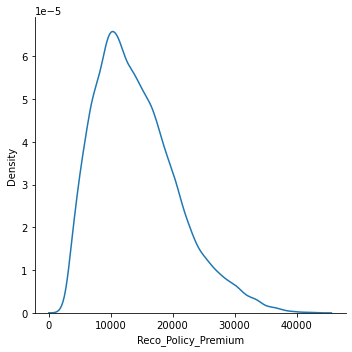

In [ ]:
sns.displot(train_data['Reco_Policy_Premium'],kind='kde')


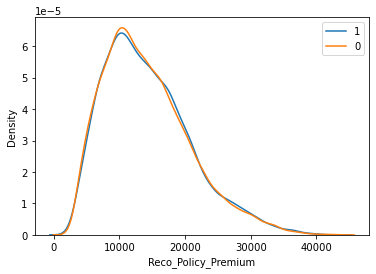

In [ ]:
sns.kdeplot(train_data['Reco_Policy_Premium'][train_data['Response']==1],label='1')
sns.kdeplot(train_data['Reco_Policy_Premium'][train_data['Response']==0],label='0')
plt.legend()

We see the premium distribution for response type is almost same, there is no difference in distribution for positive and negative response. Hence it does not help in explaining the Response, both category has equal likelihood.

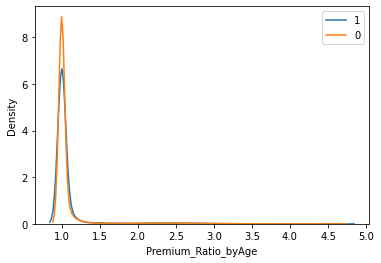

In [ ]:

sns.kdeplot(train_data['Premium_Ratio_byAge'][train_data['Response']==1],label='1')
sns.kdeplot(train_data['Premium_Ratio_byAge'][train_data['Response']==0],label='0')
plt.legend()

<AxesSubplot:xlabel='City_Code_Reco_Policy_Cat_min_Reco_Policy_Premium', ylabel='Density'>

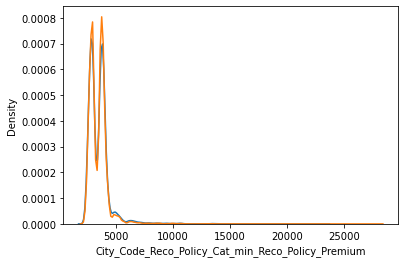

In [ ]:
sns.kdeplot(train_data['City_Code_Reco_Policy_Cat_min_Reco_Policy_Premium'][train_data['Response']==1],label='Yes')
sns.kdeplot(train_data['City_Code_Reco_Policy_Cat_min_Reco_Policy_Premium'][train_data['Response']==0],label='No')

Scaling

In [ ]:
train_data.head()

In [ ]:
categ_cols=['Holding_Policy_Duration','Holding_Policy_Type','Reco_Policy_Cat','Response','Reco_Insurance_Type','Accomodation_Type','Is_Spouse',
 'X1','X2','X3','X4','X5','X6','X7','X8','X9','Upper_Age_bin','Lowe_Age_bin','Region_Code_min_Reco_Policy_Cat','Region_Code_count_Reco_Policy_Cat',
 'Region_Code_mode_Reco_Policy_Cat','Region_Code_max_Reco_Policy_Cat']

In [ ]:
train_data.drop(['Region_Code','City_Code'],axis=1,inplace=True)
train_data.drop('ID',axis=1,inplace=True)

In [ ]:
cols=train_data.columns

In [ ]:
num_cols=[]
for i in cols:
    if i not in categ_cols:
        num_cols.append(i)

In [ ]:
num_data=train_data[num_cols]

In [ ]:
test_data.drop(['Region_Code','City_Code','ID'],axis=1,inplace=True)

In [ ]:
test_num_data=test_data[num_cols]

In [ ]:
scaler=StandardScaler()
num_scaled=scaler.fit_transform(num_data)
test_num_sclaed=scaler.transform(test_num_data)

In [ ]:
num_data=pd.DataFrame(num_scaled,columns=num_cols)

In [ ]:
test_num_data=pd.DataFrame(test_num_sclaed,columns=num_cols)

In [ ]:
train_data.drop(num_cols,axis=1,inplace=True)
test_data.drop(num_cols,axis=1,inplace=True)

D:\anacond\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [ ]:
train_data=pd.concat([num_data,train_data],axis=1)
test_data=pd.concat([test_num_data,test_data],axis=1)

In [ ]:
train_data.head()

,Reco_Policy_Premium,Lower_Age_bin,ageDiff,Premium_by_uage,Premium_by_lage,Premium_by_age_Diff,Premium_Ratio_byAge,City_Code_Reco_Policy_Cat_min_Reco_Policy_Premium,City_Code_Reco_Policy_Cat_max_Reco_Policy_Premium,City_Code_Reco_Policy_Cat_mean_Reco_Policy_Premium,City_Code_Reco_Policy_Cat_std_Reco_Policy_Premium,City_Code_Reco_Policy_Cat_skew_Reco_Policy_Premium,Region_Code_Reco_Policy_Cat_min_Reco_Policy_Premium,Region_Code_Reco_Policy_Cat_max_Reco_Policy_Premium,Region_Code_Reco_Policy_Cat_mean_Reco_Policy_Premium,Region_Code_Reco_Policy_Cat_std_Reco_Policy_Premium,Region_Code_Reco_Policy_Cat_skew_Reco_Policy_Premium,Region_Code_Reco_Policy_Cat_top_ten_Reco_Policy_Premium,Region_Code_Reco_Policy_Cat_bottom_ten_Reco_Policy_Premium,Is_Spouse_Reco_Policy_Cat_min_Reco_Policy_Premium,Is_Spouse_Reco_Policy_Cat_max_Reco_Policy_Premium,Is_Spouse_Reco_Policy_Cat_mean_Reco_Policy_Premium,Is_Spouse_Reco_Policy_Cat_std_Reco_Policy_Premium,Is_Spouse_Reco_Policy_Cat_skew_Reco_Policy_Premium,Is_Spouse_Reco_Policy_Cat_top_ten_Reco_Policy_Premium,Is_Spouse_Reco_Policy_Cat_bottom_ten_Reco_Policy_Premium,Accomodation_Type_Reco_Policy_Cat_min_Reco_Policy_Premium,Accomodation_Type_Reco_Policy_Cat_max_Reco_Policy_Premium,Accomodation_Type_Reco_Policy_Cat_mean_Reco_Policy_Premium,Accomodation_Type_Reco_Policy_Cat_std_Reco_Policy_Premium,Accomodation_Type_Reco_Policy_Cat_skew_Reco_Policy_Premium,Accomodation_Type_Reco_Policy_Cat_top_ten_Reco_Policy_Premium,Accomodation_Type_Reco_Policy_Cat_bottom_ten_Reco_Policy_Premium,Holding_Policy_Type_Reco_Policy_Cat_min_Reco_Policy_Premium,Holding_Policy_Type_Reco_Policy_Cat_max_Reco_Policy_Premium,Holding_Policy_Type_Reco_Policy_Cat_mean_Reco_Policy_Premium,Holding_Policy_Type_Reco_Policy_Cat_std_Reco_Policy_Premium,Holding_Policy_Type_Reco_Policy_Cat_skew_Reco_Policy_Premium,Holding_Policy_Type_Reco_Policy_Cat_top_ten_Reco_Policy_Premium,Holding_Policy_Type_Reco_Policy_Cat_bottom_ten_Reco_Policy_Premium,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Response,Accomodation_Type,Reco_Insurance_Type,Is_Spouse,X1,X2,X3,X4,X5,X6,X7,X8,X9,Upper_Age_bin,Region_Code_count_Reco_Policy_Cat,Region_Code_mode_Reco_Policy_Cat
0,-0.387852,0.030543,-0.308420,0.046255,-0.160352,-0.325815,-0.254444,-0.764177,-0.114604,-0.071509,0.297683,0.235259,0.588505,-1.274354,-0.602847,NaN,NaN,-1.098984,-1.256705,-0.504860,0.833841,-0.394042,0.021729,0.611900,0.922766,-0.608232,-0.755486,0.845273,-1.105835,-1.006320,1.176782,0.147513,-1.504497,0.479256,1.061709,0.865734,0.476490,-0.298932,1.323858,0.035778,14.0,3.0,22,0.0,0,0,0,1,0,0,0,0,0,0,0,0,1,10,21
1,2.477394,-1.373350,7.411520,0.956236,5.333453,-0.195775,7.236821,0.697524,0.707205,-0.145928,0.833524,0.979933,-0.893675,2.261469,0.795127,1.454273,0.343933,1.775383,1.195387,-0.504860,0.833841,-0.394042,0.021729,0.611900,0.922766,-0.608232,0.012638,0.866272,1.147877,1.451797,-0.866870,1.478625,0.119406,-1.231516,0.986413,-0.825767,0.943926,0.883018,1.154169,-1.314834,-999.0,-999.0,22,0.0,1,1,0,0,1,0,0,0,0,0,0,0,4,21,22
2,-1.021842,-0.671403,-0.308420,-0.933087,-0.626101,-0.325815,-0.254444,1.058120,-0.518217,0.164600,-0.432025,-0.195006,-0.231265,-1.598011,-1.389838,-1.884373,NaN,-1.033331,-1.146835,-0.366913,1.067695,-0.280443,-0.320199,0.434512,0.539555,-0.337338,0.549273,1.118268,1.044516,0.707604,-0.785001,0.797965,0.937443,0.880510,1.306419,0.583601,-0.828426,-0.744822,0.487239,0.157703,1.0,1.0,19,1.0,1,0,0,1,0,0,0,0,0,0,0,0,1,8,1
3,0.545682,0.732490,0.274217,0.251740,0.084519,0.676786,0.004688,0.813430,1.394590,0.818122,0.991012,1.125645,1.795597,-0.491060,0.838096,NaN,NaN,-1.016690,-1.118987,-0.366913,1.067695,-0.280443,-0.320199,0.434512,0.539555,-0.337338,0.549273,1.118268,1.044516,0.707604,-0.785001,0.797965,0.937443,1.048477,-0.408905,1.446644,1.278233,-1.262168,0.270397,0.727363,14.0,3.0,19,0.0,1,1,0,1,0,0,0,0,0,0,0,0,3,5,2
4,-0.573588,0.030543,-0.308420,-0.893538,-0.607293,-0.325815,-0.254444,0.530105,-0.299753,-0.474400,-1.025972,0.471311,0.190589,0.164910,

In [ ]:
train_y=train_data[['Response']]
train_data.drop('Response',axis=1,inplace=True)

Modeling

For heavily unbalanced datasets such as 1:10000:

max_bin: keep it only for memory pressure, not to tune (otherwise overfitting)

learning rate: keep it only for training speed, not to tune (otherwise overfitting)

n_estimators: must be infinite (like 9999999) and use early stopping to auto-tune (otherwise overfitting)

num_leaves: [7, 4095]

max_depth: [2, 63] and infinite (I personally saw metric performance increases with such 63 depth with small number of leaves on sparse unbalanced datasets)

scale_pos_weight: [1, 10000] (if over 10000, something might be wrong because I never saw it that good after 5000)

min_child_weight: [0.01, (sample size / 1000)] if you are using logloss (think about the hessian possible value range before putting "sample size / 1000", it is dataset-dependent and loss-dependent)

subsample: [0.4, 1]

bagging_freq: only 1, keep as is (otherwise overfitting)

colsample_bytree: [0.4, 1]

is_unbalance: false (make your own weighting with scale_pos_weight)

USE A CUSTOM METRIC (to reflect reality without weighting, otherwise you have weights inside your metric with premade metrics like xgboost)

Never tune these parameters unless you have an explicit requirement to tune them:

Learning rate (lower means longer to train but more accurate, higher means smaller to train but less accurate)

Number of boosting iterations (automatically tuned with early stopping and learning rate)

Maximum number of bins (RAM dependent)

In [ ]:
err = [] 


Folds=8


evals_result={}
params={'learning_rate':.04,'lambda_l2':2.88,
              'max_depth':12,
              'num_leaves':15,
              'min_data_in_leaf':30,
              'feature_fraction':.8,
              'subsample':.7,'boosting':'goss','objective':'binary','scale_pos_weight':3.2,'metric':['auc']}
x=X_train.copy()
y=y_train.copy()

oofs = np.zeros(shape=(len(x)))
preds = np.zeros(shape=(len(X_val)))
fold = StratifiedKFold(n_splits=Folds, shuffle=True, random_state=2020)
i = 1
for train_index, test_index in fold.split(x, y):
    x_train, x_val = x.iloc[train_index], x.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    tdata=lgb.Dataset(x_train,label=y_train)
    vdata=lgb.Dataset(x_val,label=y_val,reference=tdata)
    model=lgb.train(params,tdata,num_boost_round=90000,early_stopping_rounds=15,valid_sets=[tdata,vdata],valid_names=['train','valid'],evals_result=evals_result,verbose_eval=False)
    pred_y = model.predict_proba(x_val)[:,1]
    oofs[test_index] = pred_y
    print(i, " err_lgm: ", roc_auc_score(y_val,pred_y))
    err.append(roc_auc_score(y_val,pred_y))
    preds+= model.predict_proba(X_val)[:,1]
    i = i + 1
preds=preds/Folds
    
print(f"Average StratifiedKFold Score : {sum(err)/Folds} ")
oof_score = roc_auc_score(y, oofs)
oofval_score=roc_auc_score(Y_val,preds)
print(f'\nOOF Auc is : {oof_score}')
print(f'\nOOF Auc is : {oofval_score}')
    
oofs=pd.DataFrame(oofs,columns=['lgbmoof'])
preds=pd.DataFrame(preds,columns=['lgbmpred'])  


In [ ]:
X_train,X_val,y_train,Y_val=tts(train_data,train_y,test_size=.20,random_state=0)
y_train['Response'],Y_val['Response']=y_train['Response'].astype('int64'),Y_val['Response'].astype('int64')


err = [] 


Folds=8


evals_result={}
params={'learning_rate':.04,
              'max_depth':12,
              'num_leaves':15,
              'min_child_samples':30,
              'colsample_bytree':.8,
              'subsample':.1,'boosting_type':'goss','objective':'binary','scale_pos_weight':3.2,'metric':['auc'],'n_estimators':99999}
x=X_train.copy()
y=y_train.copy()

oofs = np.zeros(shape=(len(x)))
preds = np.zeros(shape=(len(X_val)))
fold = StratifiedKFold(n_splits=Folds, shuffle=True, random_state=2020)
i = 1
for train_index, test_index in fold.split(x, y):
    x_train, x_val = x.iloc[train_index], x.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    model=LGBMClassifier(**params)
    model.fit(np.asarray(x_train),np.asarray(y_train).ravel(),eval_set=[(np.asarray(x_train),np.asarray(y_train).ravel()),(np.asarray(x_val),np.asarray(y_val).ravel())],eval_names=['valid','train'],early_stopping_rounds=30,eval_metric='auc',verbose=0)
    pred_y = model.predict_proba(np.asarray(x_val))[:,1]
    oofs[test_index] = pred_y
    print(i, " err_lgm: ", roc_auc_score(y_val,pred_y))
    err.append(roc_auc_score(y_val,pred_y))
    preds+= model.predict_proba(X_val)[:,1]
    i = i + 1
preds=preds/Folds
    
print(f"Average StratifiedKFold Score : {sum(err)/Folds} ")
oof_score = roc_auc_score(y, oofs)
oofval_score=roc_auc_score(Y_val,preds)
print(f'\nOOF Auc is : {oof_score}')
print(f'\nOOF Validation Auc is : {oofval_score}')
    
oofs=pd.DataFrame(oofs,columns=['lgbmoof'])
preds=pd.DataFrame(preds,columns=['lgbmpred'])  


<ipython-input-232-15d5e2347871>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['Response'],Y_val['Response']=y_train['Response'].astype('int64'),Y_val['Response'].astype('int64')


1  err_lgm:  0.7965466136502741
2  err_lgm:  0.80457358816377
3  err_lgm:  0.7876685792495794
4  err_lgm:  0.8093056363440024
5  err_lgm:  0.8054381564231412
6  err_lgm:  0.8068697714847157
7  err_lgm:  0.8118142374293591
8  err_lgm:  0.8031768372073804
Average StratifiedKFold Score : 0.8031741774940279 

OOF Auc is : 0.8031009779714766

OOF Validation Auc is : 0.8028424558365562


In [ ]:
evals_result=model.evals_result_

In [ ]:
def render_metric(metric_name):
    ax = lgb.plot_metric(evals_result, metric=metric_name, figsize=(10, 5))
    plt.show()

In [ ]:
if INTERACTIVE:
    # create widget to switch between metrics
    interact(render_metric, metric_name=params['metric'])
else:
    render_metric(params['metric'][0])

interactive(children=(Dropdown(description='metric_name', options=('auc',), value='auc'), Output()), _dom_clas…

In [ ]:
X_train,X_val,y_train,Y_val=tts(train_data,train_y,test_size=.20,random_state=0)
y_train['Response'],Y_val['Response']=y_train['Response'].astype('int64'),Y_val['Response'].astype('int64')

<ipython-input-71-79339f95a4a4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['Response'],Y_val['Response']=y_train['Response'].astype('int64'),Y_val['Response'].astype('int64')


In [ ]:
params={'num_leaves':7,'max_depth':3,'colsample_bytree':.5,'scale_pos_weight':.65,'boosting_type':'goss','objective':'binary','n_estimators':9999999,'metric':['auc'],'random_state':100}


In [ ]:
model=LGBMClassifier(**params)
model.fit(np.asarray(X_train),np.asarray(y_train).ravel(),eval_set=[(np.asarray(X_train),np.asarray(y_train).ravel()),(np.asarray(X_val),np.asarray(Y_val).ravel())],eval_names=['valid','train'],early_stopping_rounds=30)

[1]	valid's auc: 0.731078	train's auc: 0.728424
Training until validation scores don't improve for 30 rounds
[2]	valid's auc: 0.758871	train's auc: 0.756837
[3]	valid's auc: 0.76905	train's auc: 0.763542
[4]	valid's auc: 0.770635	train's auc: 0.764146
[5]	valid's auc: 0.774243	train's auc: 0.768057
[6]	valid's auc: 0.776256	train's auc: 0.770591
[7]	valid's auc: 0.776808	train's auc: 0.771765
[8]	valid's auc: 0.777781	train's auc: 0.773223
[9]	valid's auc: 0.778409	train's auc: 0.773858
[10]	valid's auc: 0.77953	train's auc: 0.774768
[11]	valid's auc: 0.779416	train's auc: 0.774238
[12]	valid's auc: 0.780219	train's auc: 0.774826
[13]	valid's auc: 0.780493	train's auc: 0.774553
[14]	valid's auc: 0.780806	train's auc: 0.775054
[15]	valid's auc: 0.781772	train's auc: 0.775337
[16]	valid's auc: 0.782094	train's auc: 0.775479
[17]	valid's auc: 0.782719	train's auc: 0.776473
[18]	valid's auc: 0.782891	train's auc: 0.776329
[19]	valid's auc: 0.78424	train's auc: 0.777566
[20]	valid's auc: 0.

[181]	valid's auc: 0.81533	train's auc: 0.795221
[182]	valid's auc: 0.815359	train's auc: 0.795371
[183]	valid's auc: 0.815453	train's auc: 0.795411
[184]	valid's auc: 0.815451	train's auc: 0.795316
[185]	valid's auc: 0.815445	train's auc: 0.795311
[186]	valid's auc: 0.815501	train's auc: 0.795303
[187]	valid's auc: 0.815546	train's auc: 0.795322
[188]	valid's auc: 0.815783	train's auc: 0.795593
[189]	valid's auc: 0.815815	train's auc: 0.795559
[190]	valid's auc: 0.815948	train's auc: 0.795499
[191]	valid's auc: 0.815894	train's auc: 0.795171
[192]	valid's auc: 0.81607	train's auc: 0.795192
[193]	valid's auc: 0.816142	train's auc: 0.795293
[194]	valid's auc: 0.816199	train's auc: 0.795338
[195]	valid's auc: 0.816157	train's auc: 0.795088
[196]	valid's auc: 0.816276	train's auc: 0.794924
[197]	valid's auc: 0.816411	train's auc: 0.79492
[198]	valid's auc: 0.816525	train's auc: 0.795097
[199]	valid's auc: 0.816647	train's auc: 0.795111
[200]	valid's auc: 0.816749	train's auc: 0.795049
[20

LGBMClassifier(boosting_type='goss', colsample_bytree=0.5, max_depth=3,
               metric=['auc'], n_estimators=9999999, num_leaves=7,
               objective='binary', random_state=100, scale_pos_weight=0.65)

In [ ]:
num_classes=2
y_train.shape[0]/(num_classes*np.bincount(y_train.Response))

array([0.65621473, 2.1003612 ])

In [ ]:
evals_result=model.evals_result_
def render_metric(metric_name):
    ax = lgb.plot_metric(evals_result, metric=metric_name, figsize=(10, 5))
    plt.show()
    
if INTERACTIVE:
    # create widget to switch between metrics
    interact(render_metric, metric_name=params['metric'])
else:
    render_metric(params['metric'][0])

interactive(children=(Dropdown(description='metric_name', options=('auc',), value='auc'), Output()), _dom_clas…